In [1]:
import astropy.stats as apy

In [2]:
import bk.load
import bk.compute
import bk.plot
import bk.signal

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

In [4]:
import matplotlib.pyplot as plt

In [5]:
import scipy.signal
import scipy.stats

In [ ]:
bk.load.lfp_in_intervals()

In [10]:
bk.load.current_session_linux()
states = bk.load.states()
lfp = bk.load.lfp_in_intervals(15,states['Rem'])
lfp_filt = bk.signal.passband(lfp,4,12)
power,phase = bk.signal.hilbert(lfp_filt)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


In [11]:
f, Pxx= sp.signal.welch(lfp.values,fs = 1250,nperseg=5000,noverlap=4000)

(0.0, 20.0)

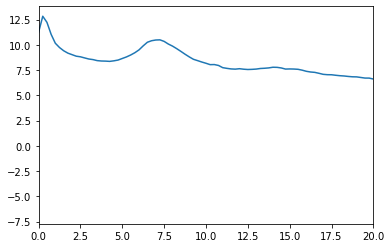

In [12]:
plt.plot(f,np.log(Pxx))
plt.xlim(0,20)

In [13]:
neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    
neurons_phase = []
for i,n in enumerate(neurons):
    neurons_phase.append(phase.realign(n.restrict(states['Rem'])))

Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [11]:
%matplotlib qt

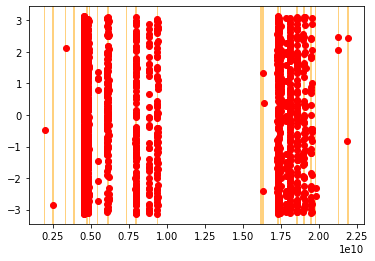

In [14]:
plt.plot(neurons_phase[0].times(),neurons_phase[0].values,'ro')
bk.plot.intervals(states['Rem'],time_units='us')

In [15]:
a = []
for i,p in enumerate(neurons_phase):
    pvalue = apy.rayleightest(p.values)
    a.append(np.nanmean(p))
#     if pvalue < 0.001 and rvalue > 0.04: print(1)

In [16]:
%matplotlib qt

In [17]:
for i in range(20):
    fig,ax = plt.subplot_mosaic('''
                                A.
                                BC
                                ''')
    polar_ax = fig.add_subplot(2,2,2,polar=True)                                       
    ax['A'].plot(lfp)
    ax['A'].plot(lfp_filt)
    plt.sca(ax['A'])
    bk.plot.intervals(states['Rem'],time_units='us')
    ax['B'].plot(phase)
    ax['B'].plot(neurons_phase[i],'ro')

    h,a = np.histogram(neurons_phase[i].values,50)
    a = np.convolve(a,[.5,.5],'same')[1::]
    
    ax['C'].bar(a,h,a[1]-a[0])
    ax['C'].bar(a+2*np.pi,h,a[1]-a[0])

#     ax['C'].bar(neurons_phase[i].values+(2*np.pi),50,'blue')

    ax['A'].get_shared_x_axes().join(ax['A'], ax['B'])
    polar_ax.bar(a,h,a[1]-a[0])
    
    plt.suptitle(f'Neuron #{i}')

# plt.subplot(211)
# plt.plot(lfp)
# plt.plot(lfp.times(),lfp_filt)

In [243]:
h.shape

(50,)

In [247]:
t

array([-3.07790296, -2.95227438, -2.82664579, -2.70101721, -2.57538863,
       -2.44976005, -2.32413147, -2.19850289, -2.0728743 , -1.94724572,
       -1.82161714, -1.69598856, -1.57035998, -1.4447314 , -1.31910281,
       -1.19347423, -1.06784565, -0.94221707, -0.81658849, -0.69095991,
       -0.56533132, -0.43970274, -0.31407416, -0.18844558, -0.062817  ,
        0.06281158,  0.18844017,  0.31406875,  0.43969733,  0.56532591,
        0.69095449,  0.81658307,  0.94221166,  1.06784024,  1.19346882,
        1.3190974 ,  1.44472598,  1.57035456,  1.69598315,  1.82161173,
        1.94724031,  2.07286889,  2.19849747,  2.32412605,  2.44975464,
        2.57538322,  2.7010118 ,  2.82664038,  2.95226896,  3.07789754])